# Exploración de conversaciones de U-Cursos

Foro institucional de ingeniería:

- 1,376,786 mensajes
- 96,667 temas (96,421 temas existentes?)
- hay 246 temas que al parecer ya no existen
- 11,341 usuarios
- desde el 2002-03-11 12:16:44 al 2019-08-01 12:44:51
- distribucion de genero en los mensajes: M: 1,214,446, F: 156,381, NA: 29

# Cargar librerías

In [2]:
%load_ext sql
%env DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos

env: DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos


In [466]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm

import spacy
import pickle
from datetime import datetime

from unionfind import UnionFind
from typing import List, Set, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 5]

import statistics

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout


from functools import lru_cache

from dataclasses import dataclass

### Estructuras

In [111]:
Pair = Tuple[int, int]

@dataclass
class Tema:
    raiz: int
    titulo: str
    mensajes: Set[int]
    conversacion: Set[Pair]
    fecha_creacion: datetime
        
    def __eq__(self, o):
        if not isinstance(o, Tema):
            return NotImplemented
        return self.raiz == o.raiz
    
    def __len__(self):
        return len(self.mensajes)
    
    def __hash__(self):
        return self.raiz
    
    def __str__(self):
        return f"Tema(raiz={self.raiz}, titulo='{self.titulo}', mensajes={len(self.mensajes)}, conversaciones={len(self.conversacion)}, fecha_creacion='{self.fecha_creacion}')"

    def __repr__(self):
        return self.__str__()
    
    
@dataclass
class Mensaje:
    id_: int
    contenido: str
    autor: int
    genero: str
    es_raiz: bool
    fecha_creacion: datetime
    
    def __eq__(self, o):
        if not isinstance(o, Mensaje):
            return NotImplemented
        return self.id_ == o.id_
    
    def __hash__(self):
        return self.id_

In [238]:
def plot_tema(tema):
    """Grafica tema como grafo"""
    ## crea grafo dirigido
    G = nx.DiGraph()
    
    ## agrega nodos y aristas al grafo, con atributos de cada nodo
    for m1_id, m2_id in tema.conversacion:
        m1 = mensajes[m1_id]
        m2 = mensajes[m2_id]
        G.add_node(m1)
        G.add_node(m2)
        G.add_edge(m1, m2)

    node_colors = ['green' if node.genero == 'M' else 'orange' for node in G.nodes]
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.title(f"({tema.raiz}) ''{tema.titulo}'' - {tema.fecha_creacion}")
    pos = graphviz_layout(G, prog='dot')
    nx.draw(G, pos, node_color=node_colors, with_labels=False, arrows=True, font_weight='bold')

In [113]:
def random_tema(temas):
    return np.random.choice(temas)

In [574]:
# para explorar una lista

def summarize(l: List[int]):
    print("Size:", len(l), sep="\t")
    print("Min:", min(l), sep="\t")
    print("Median:", statistics.median(l), sep="\t")
    print("Max:", max(l), sep="\t")
    print("Avg:", sum(l) / len(l), sep="\t")
    print("Mode:", statistics.mode(l), sep="\t")

### Cargar datos (dataset completo)

In [114]:
%%time

with open('../data/python/temas.obj.pkl', 'rb') as f:
    temas = pickle.load(f)
    
with open('../data/python/mensajes.obj.pkl', 'rb') as f:
    mensajes = pickle.load(f)

CPU times: user 11.1 s, sys: 2.7 s, total: 13.8 s
Wall time: 21.8 s


In [115]:
temas[1835011]

Tema(raiz=1835011, titulo='Vendo Impresora láser, WIFI, a $30.000', mensajes=1, conversaciones=0, fecha_creacion='2015-12-07 13:27:42')

In [116]:
len(temas[1835011])

1

In [117]:
mensajes[1835011]

Mensaje(id_=1835011, contenido='Hola, estoy vendiendo esta impresora http://www.ripley.cl/ripley-chile/multifuncional-samsung-sl-m2020w-xbh-2000354220305p\r\nEsta 100% nueva, en su caja.\r\n\r\nEl precio de referencia en Ripley.cl es de $50.000\r\n\r\nLa entrega es en Beauchef 851\r\nCualquier duda o consulta, este es mi correo febrito@ing.uchile.cl##@@##2078', autor=955, genero='M', es_raiz=True, fecha_creacion=datetime.datetime(2015, 12, 7, 13, 27, 42))

In [96]:
# temas con todas las respuestas

temas_101 = [tema for tema in temas.values() if len(tema) > 100]

### Viz Grafos

/Users/mquezada/anaconda3/envs/u-cursos/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/mquezada/anaconda3/envs/u-cursos/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


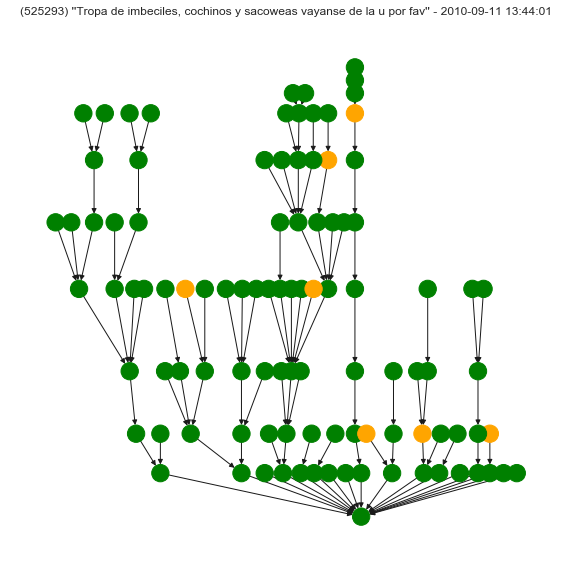

In [449]:
plot_tema(random_tema(temas_101))

# Distribución de género

In [100]:
total_mf = Counter()

for tema in tqdm(temas.values()):
    total_mf.update([m.genero for m in [mensajes[m] for m in tema.mensajes]])       

In [101]:
total_mf

Counter({'M': 1214446, 'F': 156381, '': 29})

In [204]:
tema_genero = dict()

for raiz, tema in tqdm(temas.items()):
    mf = Counter([m.genero for m in [mensajes[m] for m in tema.mensajes]])
    tema_genero[raiz] = mf

In [206]:
records = []
for raiz, counter in tema_genero.items():
    records.append((raiz, counter.get('M', 0), counter.get('F', 0), temas[raiz].fecha_creacion))
    
genero_df = pd.DataFrame.from_records(records, columns=['tema_id', 'M', 'F', 'fecha'])
genero_df['mensajes'] = genero_df['M'] + genero_df['F']
genero_df['frac_M'] = genero_df['M'] / genero_df['mensajes']
genero_df['frac_F'] = genero_df['F'] / genero_df['mensajes']

genero_df.head()

,tema_id,M,F,fecha,mensajes,frac_M,frac_F
0,2204304,6,1,2019-03-15 12:51:56,7,0.857143,0.142857
1,64582,1,0,2008-08-30 00:11:00,1,1.000000,0.000000
2,2203704,3,4,2019-03-14 00:23:19,7,0.428571,0.571429
3,2205306,2,0,2019-03-18 15:33:35,2,1.000000,0.000000
4,359250,32,4,2010-04-14 11:51:09,36,0.888889,0.111111


## Cantidad de mensajes promedio por tema en el tiempo

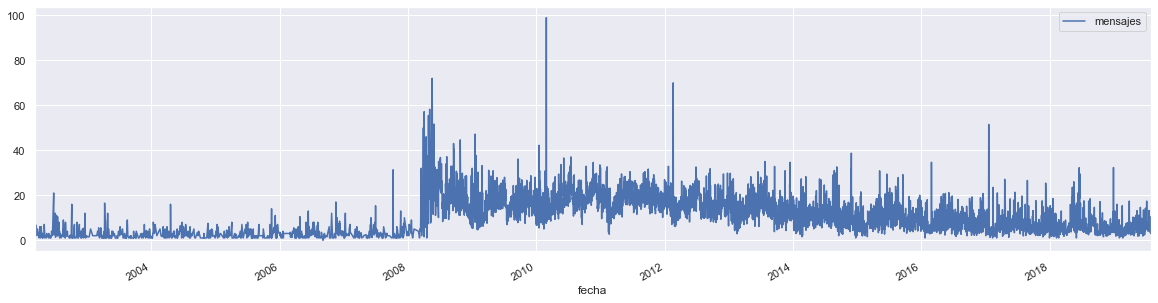

In [213]:
## por dia

msg_df = genero_df[['fecha', 'mensajes']].set_index('fecha').groupby(pd.Grouper(freq='D')).mean()
msg_df = msg_df.dropna()
msg_df.reset_index().plot.line(x='fecha', y='mensajes')

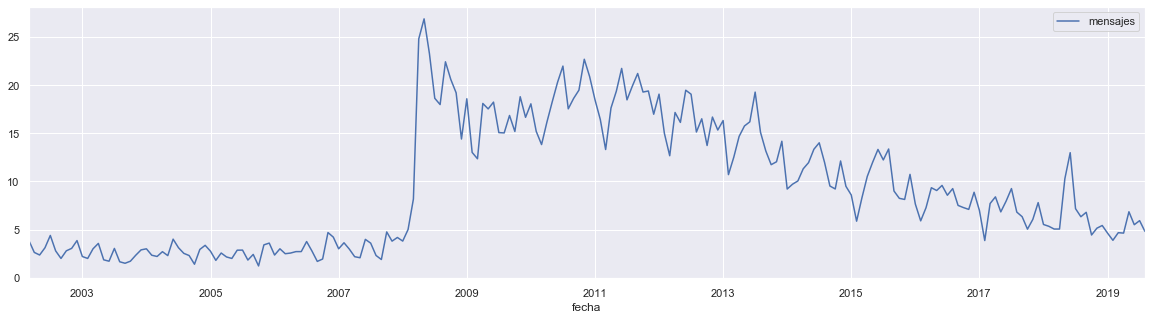

In [214]:
## por mes

msg_df = genero_df[['fecha', 'mensajes']].set_index('fecha').groupby(pd.Grouper(freq='M')).mean()
msg_df = msg_df.dropna()
msg_df.reset_index().plot.line(x='fecha', y='mensajes')

## Participación de hombres/mujeres en el tiempo

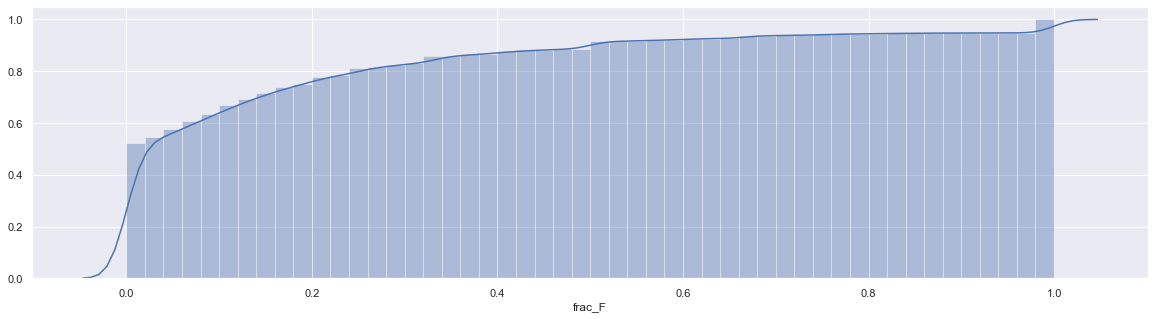

In [228]:
frac_F = genero_df['frac_F'].dropna()

sns.distplot(frac_F,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

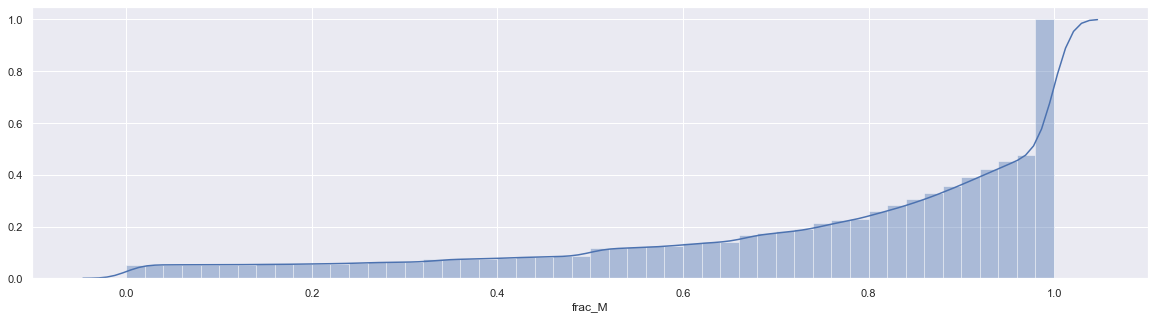

In [229]:
frac_F = genero_df['frac_M'].dropna()

sns.distplot(frac_F,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

In [175]:
# antes de abril 2008 hay muy pocos datos
genero = genero.loc[genero['fecha'] > datetime(2008,4,1)]
genero.head()

,tema_id,M,F,fecha,mensajes,frac_M,frac_F
0,2204304,6,1,2019-03-15 12:51:56,7,0.857143,0.142857
1,64582,1,0,2008-08-30 00:11:00,1,1.000000,0.000000
2,2203704,3,4,2019-03-14 00:23:19,7,0.428571,0.571429
3,2205306,2,0,2019-03-18 15:33:35,2,1.000000,0.000000
4,359250,32,4,2010-04-14 11:51:09,36,0.888889,0.111111


In [178]:
promedio_por_dia = genero.set_index('fecha').groupby(pd.Grouper(freq='D')).mean()
promedio_por_dia = promedio_por_dia.dropna()
promedio_por_dia.head()

,tema_id,M,F,mensajes,frac_M,frac_F
fecha,,,,,,
2008-04-01,16816.400000,15.200000,3.800000,19.0,0.912821,0.087179
2008-04-02,16866.500000,1.500000,0.000000,1.5,1.000000,0.000000
2008-04-03,16922.400000,48.800000,8.400000,57.2,0.832264,0.167736
2008-04-04,17077.666667,7.666667,4.333333,12.0,0.809524,0.190476
2008-04-05,17152.000000,6.000000,1.000000,7.0,0.857143,0.142857


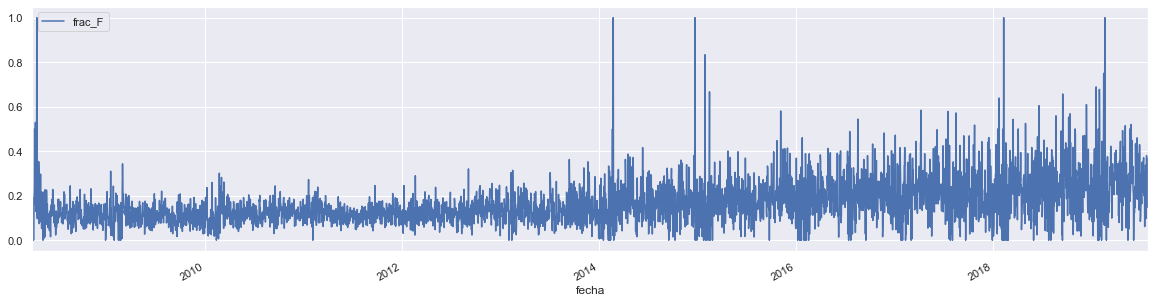

In [198]:
plt.rcParams['figure.figsize'] = [20, 5]
promedio_por_dia.reset_index().plot.line(x='fecha', y='frac_F')

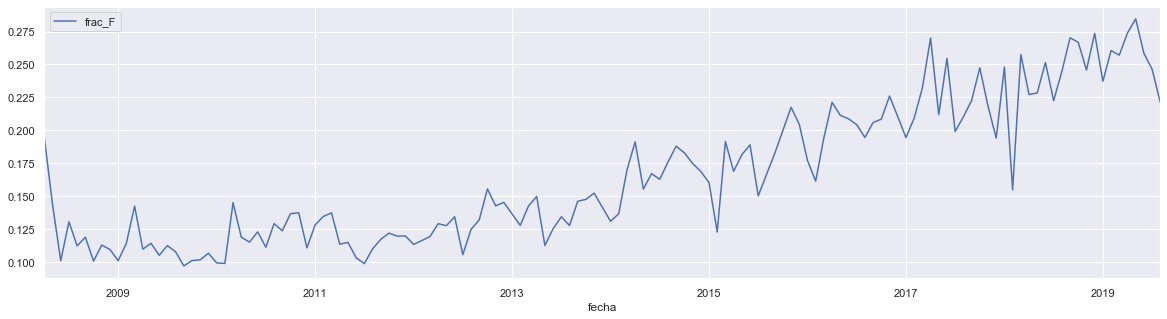

In [200]:
## promedio por mes

promedio_por_dia = genero.set_index('fecha').groupby(pd.Grouper(freq='M')).mean()
promedio_por_dia = promedio_por_dia.dropna()
plt.rcParams['figure.figsize'] = [20, 5]
promedio_por_dia.reset_index().plot.line(x='fecha', y='frac_F')

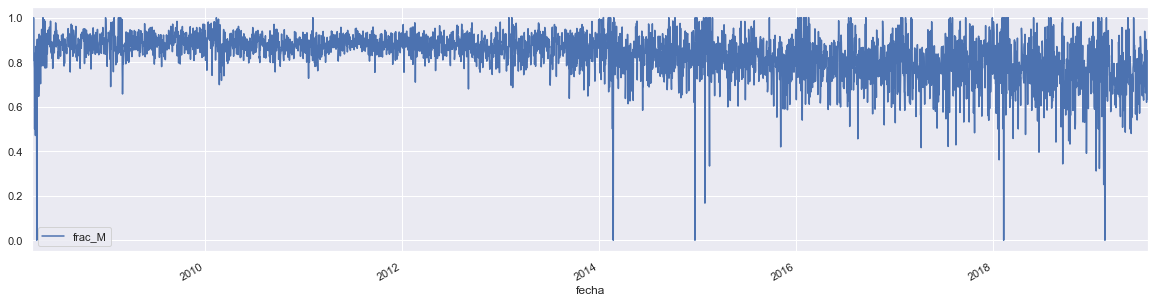

In [202]:
## promedio por dia

promedio_por_dia = genero.set_index('fecha').groupby(pd.Grouper(freq='D')).mean()
promedio_por_dia = promedio_por_dia.dropna()
plt.rcParams['figure.figsize'] = [20, 5]
promedio_por_dia.reset_index().plot.line(x='fecha', y='frac_M')

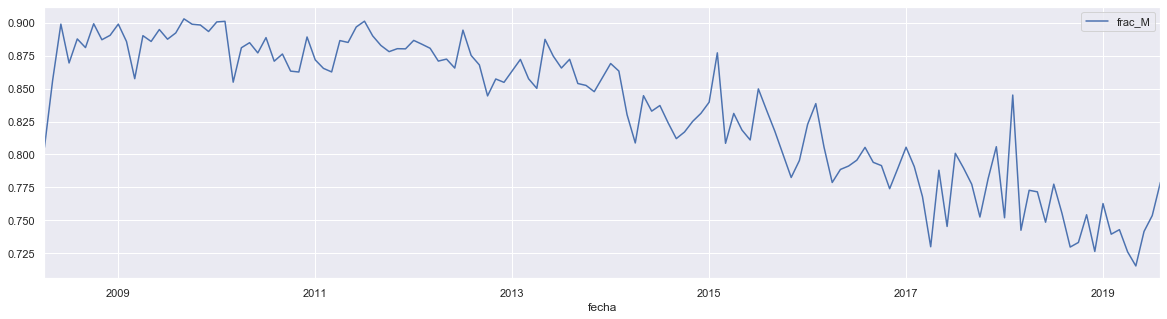

In [203]:
## promedio por mes

promedio_por_dia = genero.set_index('fecha').groupby(pd.Grouper(freq='M')).mean()
promedio_por_dia = promedio_por_dia.dropna()
plt.rcParams['figure.figsize'] = [20, 5]
promedio_por_dia.reset_index().plot.line(x='fecha', y='frac_M')

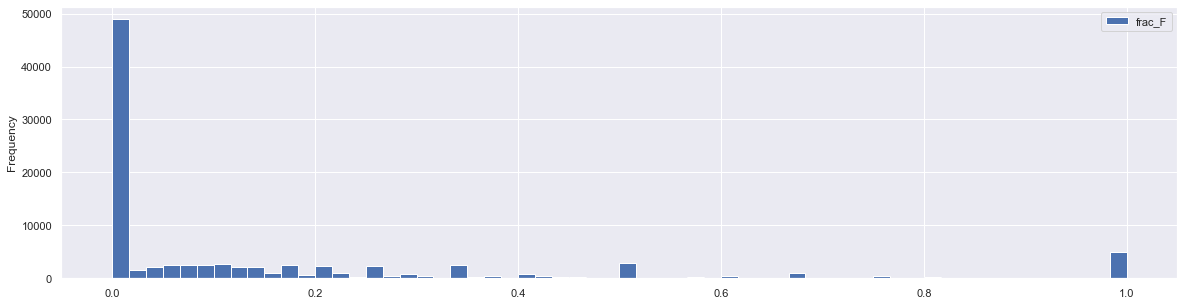

In [196]:
plt.rcParams['figure.figsize'] = [20, 5]
genero[['frac_F']].plot.hist(by='frac_F', bins=60)

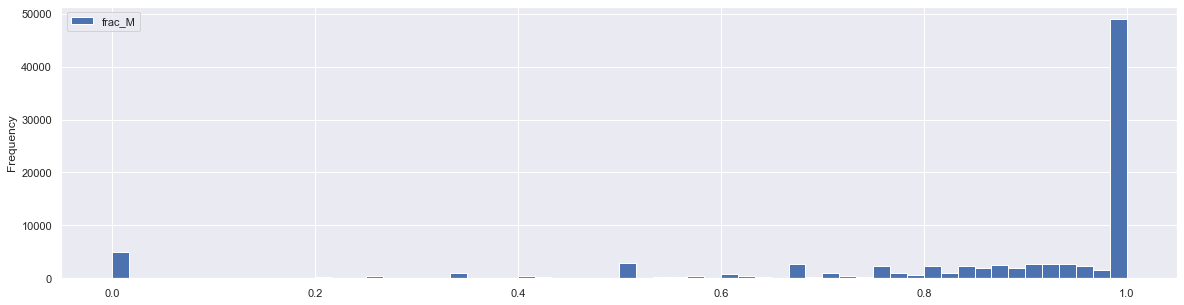

In [197]:
plt.rcParams['figure.figsize'] = [20, 5]
genero[['frac_M']].plot.hist(by='frac_M', bins=60)

In [240]:
# http://sentiment.nrc.ca/lexicons-for-research/
# https://github.com/cjhutto/vaderSentiment

## Temas, mensajes, usuarios

Un problema es cómo contar a los usuarios para determinar una distribución aceptable:



### Temas

#### Nro de temas en el tiempo

##### Por día

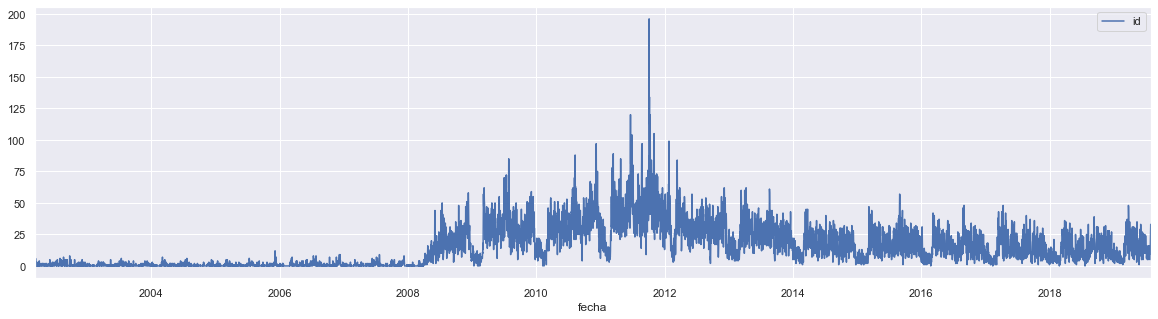

In [266]:
tema_tiempo = pd.DataFrame(([raiz, info.fecha_creacion] for raiz, info in temas.items()), columns=["id", "fecha"])
tema_tiempo = tema_tiempo.sort_values(by="fecha")

counts = tema_tiempo.set_index('fecha').groupby(pd.Grouper(freq='D')).count()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='fecha', y='id')

##### Por mes

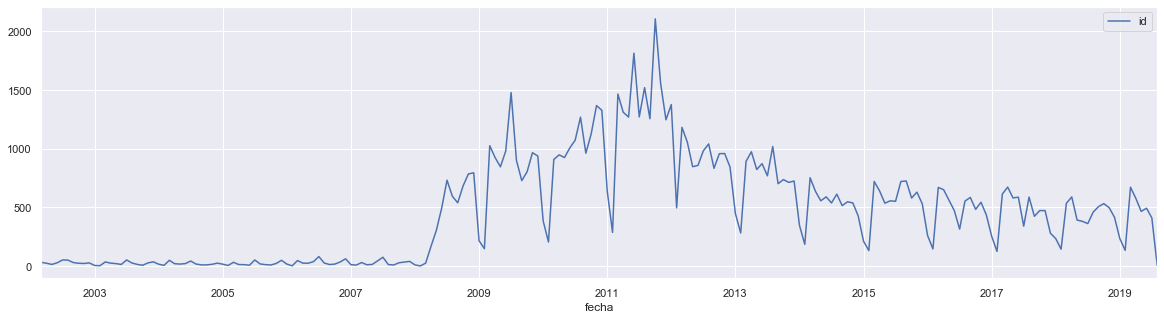

In [268]:
counts = tema_tiempo.set_index('fecha').groupby(pd.Grouper(freq='M')).count()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='fecha', y='id')

##### Tamaño promedio de temas por día

In [343]:
tema_tiempo = pd.DataFrame(([len(info.mensajes), info.fecha_creacion] for raiz, info in temas.items()), columns=["mensajes", "fecha"])
tema_tiempo = tema_tiempo.sort_values(by="fecha")
tema_tiempo.head()

,mensajes,fecha
42684,3,2002-03-11 12:16:44
30,1,2002-03-11 14:29:30
31,1,2002-03-11 20:20:12
42688,7,2002-03-11 20:35:11
42709,7,2002-03-12 11:47:30


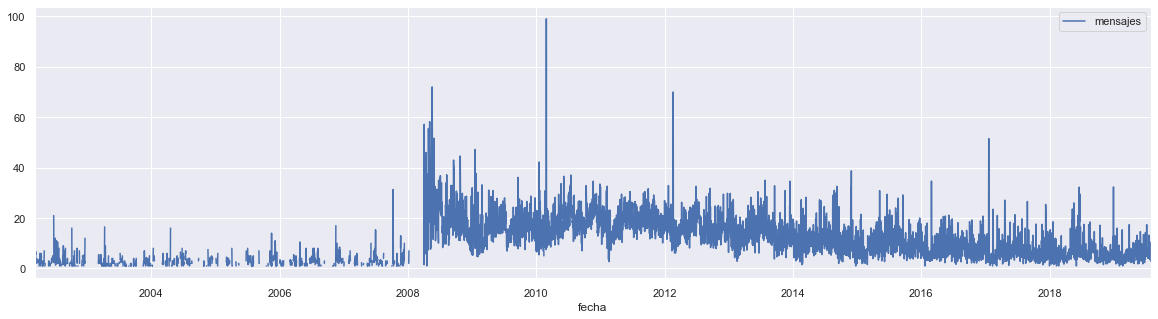

In [345]:
counts = tema_tiempo.set_index('fecha').groupby(pd.Grouper(freq='D')).mean()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='fecha', y='mensajes')

##### Tamaño promedio de temas por mes

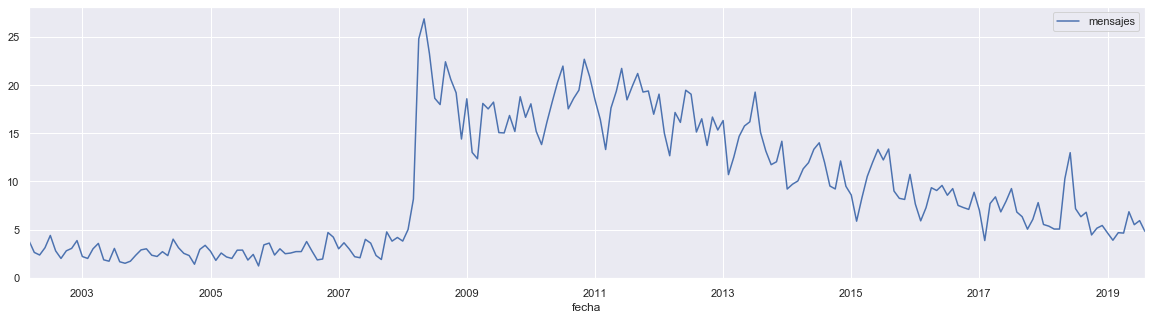

In [346]:
counts = tema_tiempo.set_index('fecha').groupby(pd.Grouper(freq='M')).mean()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='fecha', y='mensajes')

##### Tamaño mediano de temas por mes

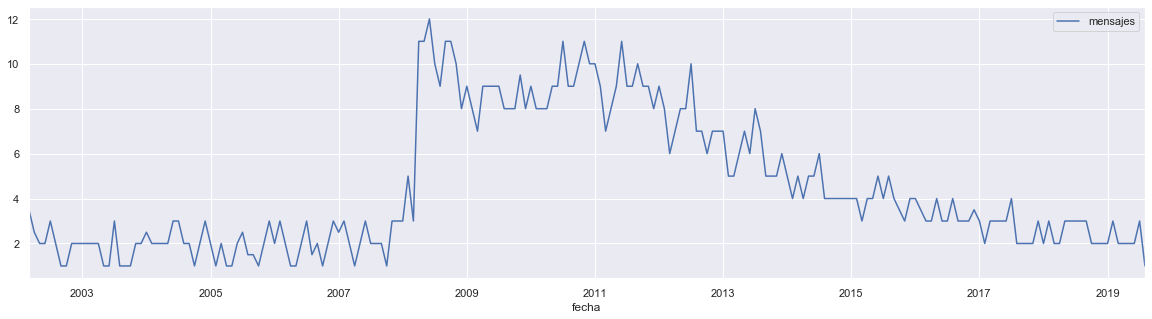

In [347]:
counts = tema_tiempo.set_index('fecha').groupby(pd.Grouper(freq='M')).median()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='fecha', y='mensajes')

### Mensajes

#### Nro de mensajes en el tiempo

##### Por día

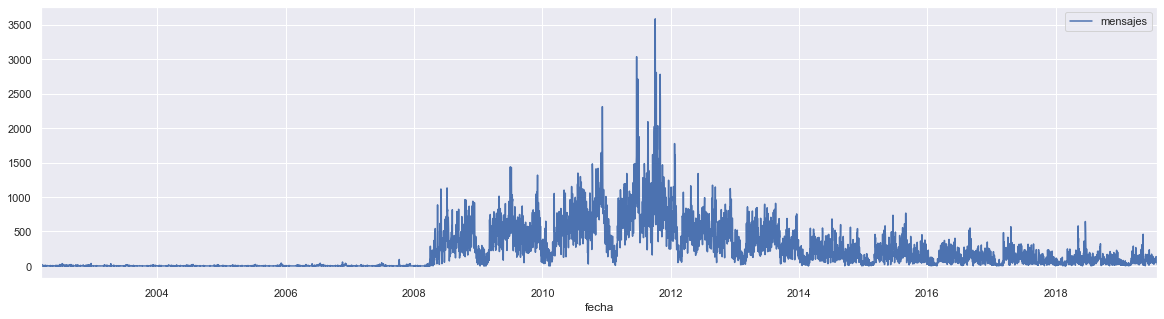

In [269]:
msjes_tiempo = pd.DataFrame(([len(info.mensajes), info.fecha_creacion] for raiz, info in temas.items()), columns=["mensajes", "fecha"])
msjes_tiempo = msjes_tiempo.sort_values(by="fecha")
counts = msjes_tiempo.set_index('fecha').groupby(pd.Grouper(freq='D')).sum()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='fecha', y='mensajes')

##### Por mes

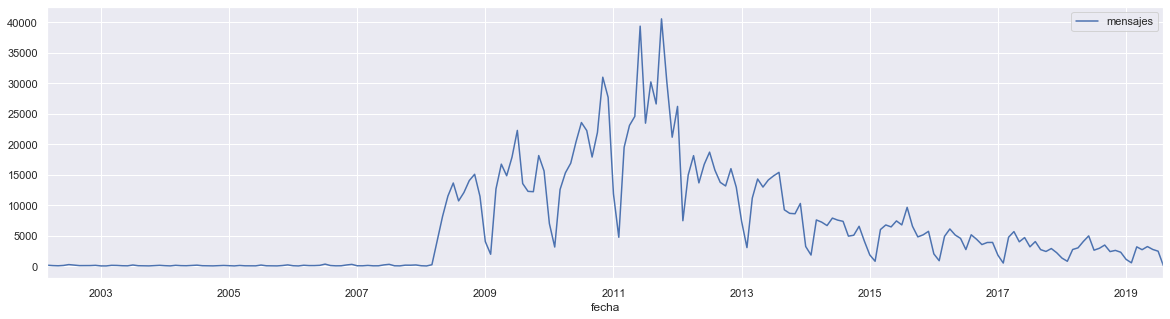

In [271]:
counts = msjes_tiempo.set_index('fecha').groupby(pd.Grouper(freq='M')).sum()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='fecha', y='mensajes')

### Usuarios

#### Total de usuarios únicos y por género

In [681]:
usuarios_df = pd.DataFrame(((m.autor, m.genero) for _, m in mensajes.items()), columns=["autor", "genero"])

In [682]:
print("total de usuarios:", len(usuarios_df['autor'].unique()))

total de usuarios: 11338


In [683]:
print("Distribucion de genero por usuarios unicos")
usuarios_df.drop_duplicates(subset=['autor'])['genero'].value_counts()

Distribucion de genero por usuarios unicos


M    8686
F    2635
       17
Name: genero, dtype: int64

In [684]:
print("Distribucion de genero por mensajes")
usuarios_df['genero'].value_counts()

Distribucion de genero por mensajes


M    1219640
F     156768
          29
Name: genero, dtype: int64

In [685]:
1219640 / 8686, 156768 / 2635

(140.41446005065623, 59.49449715370019)

#### Usuarios en el tiempo (por día)

In [326]:
usuarios_df = pd.DataFrame(((m.autor, m.genero, m.fecha_creacion) for _, m in mensajes.items()), columns=["autor", "genero", "fecha"])

usuarios_df['date'] = usuarios_df['fecha'].dt.date
usuarios_df = usuarios_df.drop_duplicates(subset=['autor', 'date']).sort_values(by="date")

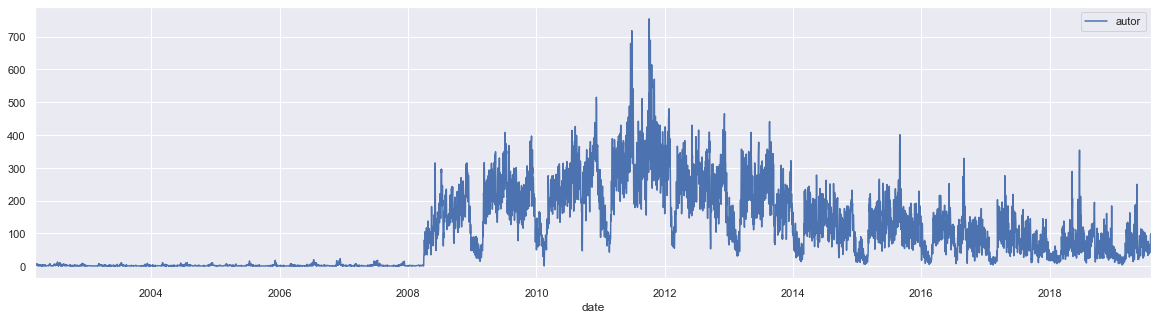

In [328]:
counts = usuarios_df.set_index('date').groupby('date').count()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='date', y='autor')

In [330]:
counts.sample(10)

,autor,genero,fecha
date,,,
2015-01-28,82,82,82
2006-05-12,1,1,1
2006-06-18,1,1,1
2014-03-10,197,197,197
2015-12-23,184,184,184
2011-05-06,327,327,327
2002-08-03,1,1,1
2018-09-20,52,52,52
2009-06-03,264,264,264


#### Usuarios únicos en el tiempo (por mes)

In [336]:
usuarios_df['mes'] = usuarios_df['fecha'].apply(lambda x: x.strftime("%Y-%m"))

In [338]:
counts = usuarios_df.drop_duplicates(['autor', 'mes']).groupby('mes').count()

counts.head()

,autor,genero,fecha,date
mes,,,,
2002-03,61,61,61,61
2002-04,40,40,40,40
2002-05,27,27,27,27
2002-06,34,34,34,34
2002-07,73,73,73,73


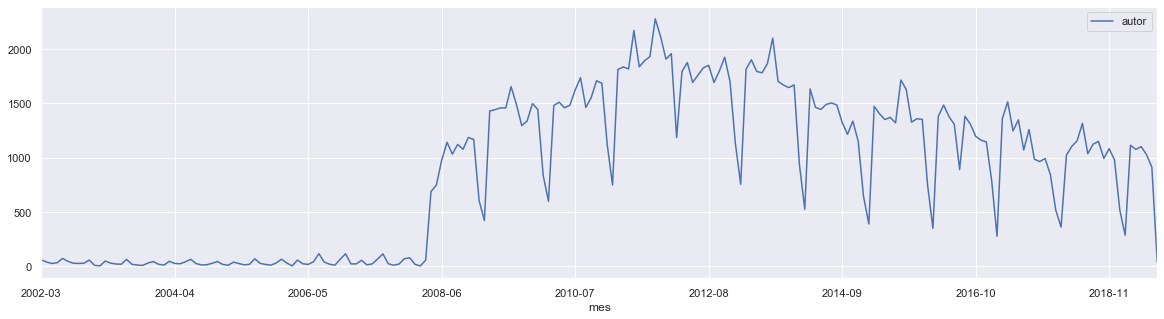

In [340]:
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='mes', y='autor')

#### Usuarios por género

##### Cantidad de posts de hombres en el tiempo

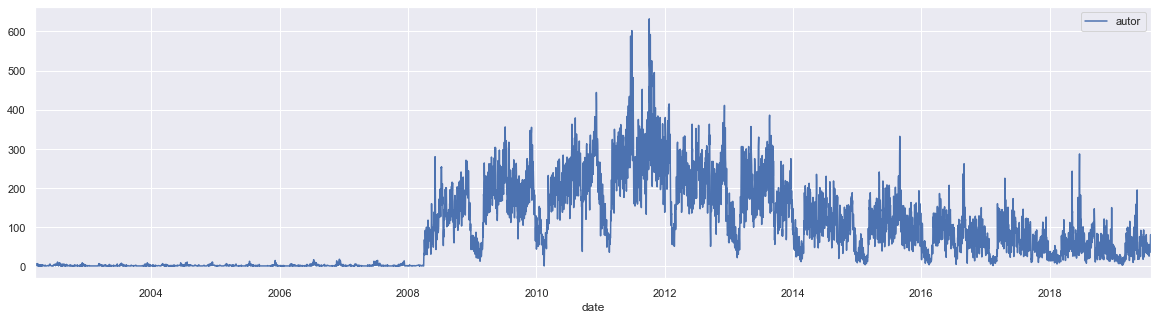

In [353]:
h = usuarios_df.loc[usuarios_df['genero'] == 'M'].drop_duplicates(['autor', 'date'])

counts = h.set_index('date').groupby('date').count()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='date', y='autor')

##### Por mes

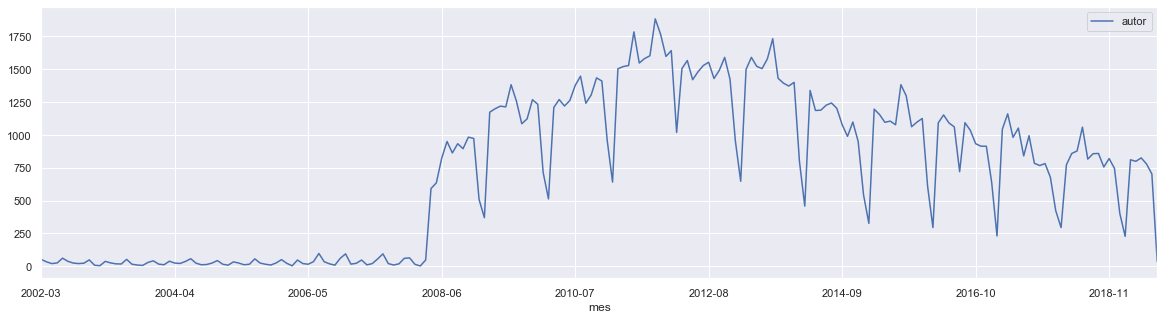

In [354]:
h = usuarios_df.loc[usuarios_df['genero'] == 'M'].drop_duplicates(['autor', 'mes'])

counts = h.set_index('mes').groupby('mes').count()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='mes', y='autor')

##### Normalizado por el total de hombres que postea en el año correspondiente

In [411]:
h = usuarios_df.loc[usuarios_df['genero'] == 'M']
h['año'] = h['mes'].apply(lambda x: int(x.split('-')[0]))

/Users/mquezada/anaconda3/envs/u-cursos/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [412]:
hombres_por_año = h.groupby("año").count()['autor']
hombres_por_año = hombres_por_año.rename('total')
hombres_por_año.head()

año
2002    593
2003    439
2004    512
2005    453
2006    751
Name: total, dtype: int64

In [422]:
counts = h.drop_duplicates(['autor', 'date']).set_index('date').groupby('date').count()
counts['date'] = counts.index
counts = counts[['autor', 'date']]
counts['año'] = counts['date'].apply(lambda d: d.year)
counts.index = counts['año'].apply(lambda x: int(x))
counts.head()

# total de hombres unicos por día

,autor,date,año
año,,,
2002,5,2002-03-11,2002
2002,3,2002-03-12,2002
2002,4,2002-03-13,2002
2002,7,2002-03-14,2002
2002,3,2002-03-15,2002


In [423]:
counts = counts.join(hombres_por_año, lsuffix='_')
counts['norm'] = counts['autor'] / counts['total']
counts.head()

# norm tiene el total por dia (autor) dividido por el total del año (total o total_)

,autor,date,año,total,norm
año,,,,,
2002,5,2002-03-11,2002,593,0.008432
2002,3,2002-03-12,2002,593,0.005059
2002,4,2002-03-13,2002,593,0.006745
2002,7,2002-03-14,2002,593,0.011804
2002,3,2002-03-15,2002,593,0.005059


In [425]:
counts = counts[['norm', 'date']]

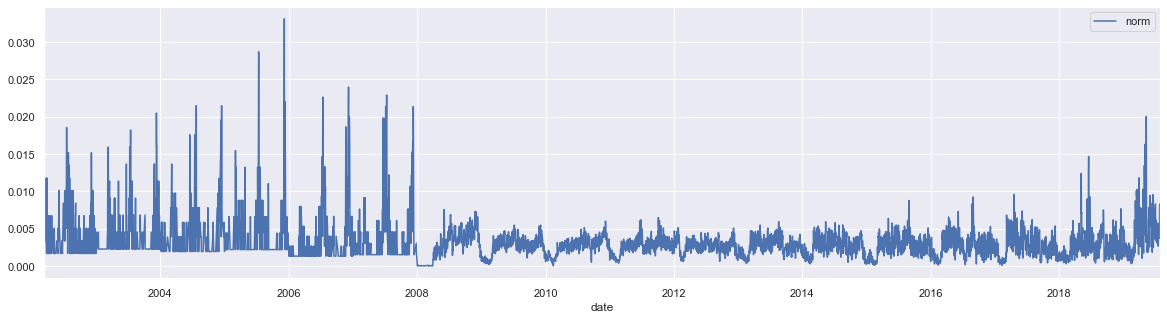

In [427]:
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='date', y='norm')

##### por mes

In [435]:
counts = h.drop_duplicates(['autor', 'date']).set_index('mes').groupby('mes').count()
counts['mes'] = counts.index
counts = counts[['autor', 'mes']]
counts['año'] = counts['mes'].apply(lambda d: int(d.split('-')[0]))
counts.index = counts['año'].apply(lambda x: int(x))

counts.sample(6)
# total de hombres unicos por mes

,autor,mes,año
año,,,
2012,7442,2012-04,2012
2004,32,2004-05,2004
2010,8377,2010-12,2010
2008,3,2008-02,2008
2009,6293,2009-05,2009
2016,2288,2016-10,2016


In [437]:
counts = counts.join(hombres_por_año, lsuffix='_')
counts['norm'] = counts['autor'] / counts['total']
counts.head()

# norm tiene el total por dia (autor) dividido por el total del año (total o total_)

,autor,mes,año,total_,norm,total
año,,,,,,
2002,76,2002-03,2002,593,0.128162,593
2002,50,2002-04,2002,593,0.084317,593
2002,23,2002-05,2002,593,0.038786,593
2002,45,2002-06,2002,593,0.075885,593
2002,138,2002-07,2002,593,0.232715,593


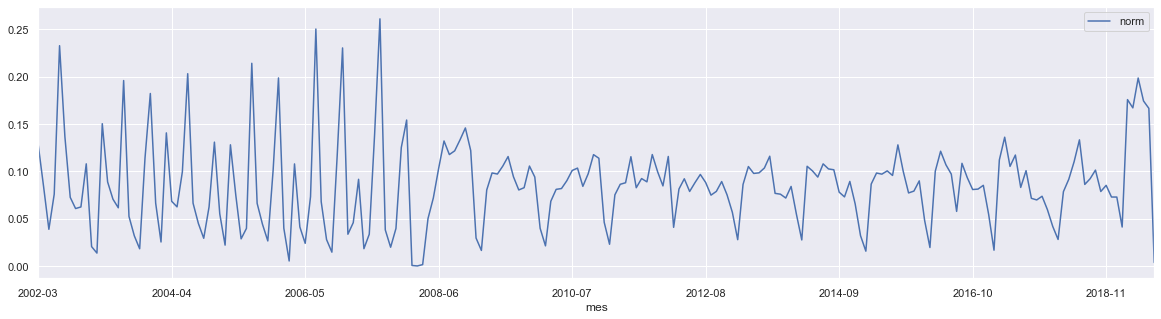

In [438]:
counts = counts[['norm', 'mes']]
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='mes', y='norm')

##### Cantidad de posts de mujeres en el tiempo

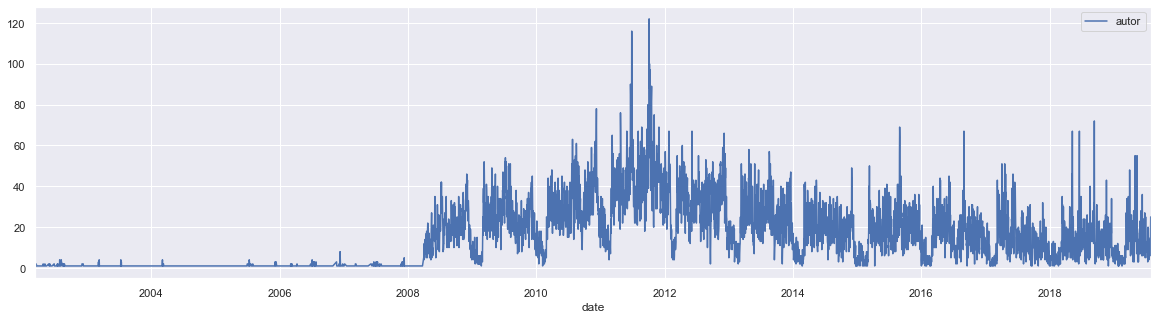

In [351]:
m = usuarios_df.loc[usuarios_df['genero'] == 'F'].drop_duplicates(['autor', 'date'])

counts = m.set_index('date').groupby('date').count()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='date', y='autor')

##### Por mes

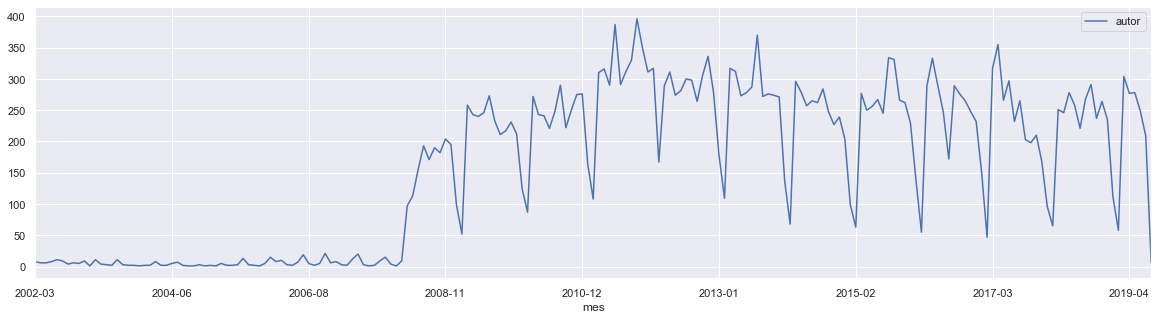

In [355]:
m = usuarios_df.loc[usuarios_df['genero'] == 'F'].drop_duplicates(['autor', 'mes'])

counts = m.set_index('mes').groupby('mes').count()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='mes', y='autor')

##### Normalizado por el total de mujeres que postea en el año correspondiente

In [439]:
h = usuarios_df.loc[usuarios_df['genero'] == 'F']
h['año'] = h['mes'].apply(lambda x: int(x.split('-')[0]))

/Users/mquezada/anaconda3/envs/u-cursos/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [440]:
hombres_por_año = h.groupby("año").count()['autor']
hombres_por_año = hombres_por_año.rename('total')
hombres_por_año.head()

año
2002    117
2003     64
2004     47
2005     72
2006    124
Name: total, dtype: int64

In [442]:
counts = h.drop_duplicates(['autor', 'date']).set_index('date').groupby('date').count()
counts['date'] = counts.index
counts = counts[['autor', 'date']]
counts['año'] = counts['date'].apply(lambda d: d.year)
counts.index = counts['año'].apply(lambda x: int(x))
counts.head()

# total de mujeres unicas por día

,autor,date,año
año,,,
2002,1,2002-03-11,2002
2002,1,2002-03-13,2002
2002,1,2002-03-14,2002
2002,1,2002-03-16,2002
2002,2,2002-03-17,2002


In [443]:
counts = counts.join(hombres_por_año, lsuffix='_')
counts['norm'] = counts['autor'] / counts['total']
counts.head()

# norm tiene el total por dia (autor) dividido por el total del año (total o total_)

,autor,date,año,total,norm
año,,,,,
2002,1,2002-03-11,2002,117,0.008547
2002,1,2002-03-13,2002,117,0.008547
2002,1,2002-03-14,2002,117,0.008547
2002,1,2002-03-16,2002,117,0.008547
2002,2,2002-03-17,2002,117,0.017094


In [444]:
counts = counts[['norm', 'date']]

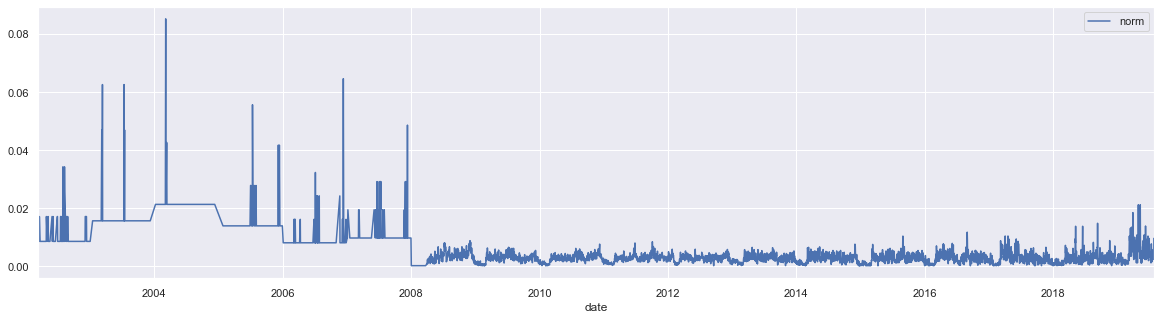

In [445]:
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='date', y='norm')

##### por mes

In [446]:
counts = h.drop_duplicates(['autor', 'date']).set_index('mes').groupby('mes').count()
counts['mes'] = counts.index
counts = counts[['autor', 'mes']]
counts['año'] = counts['mes'].apply(lambda d: int(d.split('-')[0]))
counts.index = counts['año'].apply(lambda x: int(x))

counts.sample(6)
# total de mujeres unicas por mes

,autor,mes,año
año,,,
2013,1015,2013-08,2013
2014,628,2014-05,2014
2018,434,2018-03,2018
2014,573,2014-11,2014
2004,19,2004-03,2004
2008,633,2008-09,2008


In [447]:
counts = counts.join(hombres_por_año, lsuffix='_')
counts['norm'] = counts['autor'] / counts['total']
counts.head()

# norm tiene el total por dia (autor) dividido por el total del año (total o total_)

,autor,mes,año,total,norm
año,,,,,
2002,12,2002-03,2002,117,0.102564
2002,14,2002-04,2002,117,0.119658
2002,8,2002-05,2002,117,0.068376
2002,13,2002-06,2002,117,0.111111
2002,20,2002-07,2002,117,0.170940


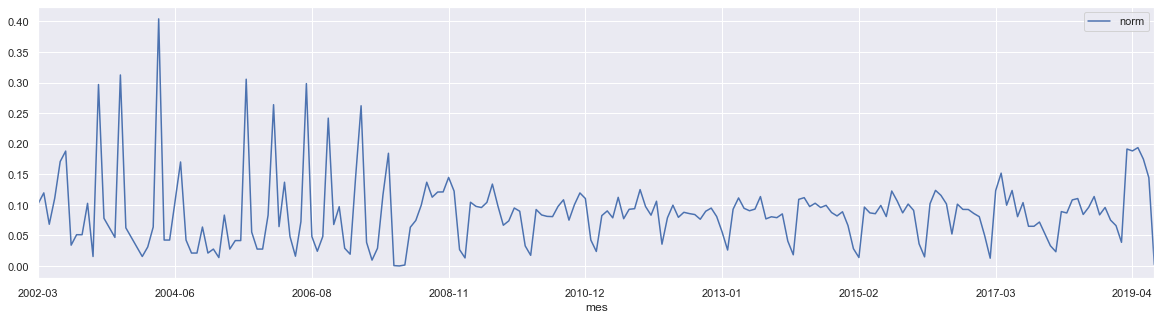

In [448]:
counts = counts[['norm', 'mes']]
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='mes', y='norm')

In [460]:
for i, t in temas.items():
    if i == 11635:
        print(t)
        print(t.mensajes)

Tema(raiz=11635, titulo='Bienvenidos al Foro de Ingeniería', mensajes=3, conversaciones=2, fecha_creacion='2002-03-11 12:16:44')
frozenset({11635, 11637, 11638})


In [464]:
m = mensajes[11635]
m

Mensaje(id_=11635, contenido='Esta es una nueva herramienta que ha \rdesarrollado la Escuela de Ingeniería y \rCiencias cuyo propósito es facilitar la \rparticipación en temas de interés para \rnuestros alumnos, exalumnos, académicos \ry autoridades de nuestra Facultad.', autor=1, genero='M', es_raiz=True, fecha_creacion=datetime.datetime(2002, 3, 11, 12, 16, 44))

## ¿de qué tamaños son los temas en los que participa un P% de hombres o mujeres?

In [627]:
def temas_con_participacion():
    _temas = []
    for raiz, tema in temas.items():
        gen = Counter([mensajes[m].genero for m in tema.mensajes])
        _temas.append((tema, gen))
    return _temas

In [628]:
temas_cp = temas_con_participacion()

In [632]:
temas_cp[1]

(Tema(raiz=64582, titulo='Ayuden a difundir el plan piloto de la ENCUESTA DOCENTE', mensajes=1, conversaciones=0, fecha_creacion='2008-08-30 00:11:00'),
 Counter({'M': 1}))

In [664]:
def explore_temas(temas, cutoff=1):
    for tema, gen in temas:
        if len(tema.mensajes) >= cutoff:
            tot = sum(gen.values())
            for g in ("M", "F"):
                print(f"{g}: {gen.get(g, 0)} ({gen.get(g, 0) / tot * 100:.1f}%) ", end="")
            print(f"T: {tot}", end=" ")
            print("-", tema.titulo)

In [665]:
explore_temas([temas_cp[2]])

M: 3 (42.9%) F: 4 (57.1%) T: 7 - Ayuda con TICs y Optimizacion


In [639]:
@lru_cache(maxsize=100)
def temas_con_mujeres(p = 0.5, at_least=True, temas_cp=temas_cp):
    filtered_temas = []
    
    for tema, gen in temas_cp:
        if at_least:
            if (gen['F'] / sum(gen.values())) >= p:
                filtered_temas.append((tema, gen))
        else:
            if (gen['F'] / sum(gen.values())) == p:
                filtered_temas.append((tema, gen))
    return filtered_temas

In [640]:
import matplotlib.ticker as ticker

def plot_tema_size(p = 0.5, at_least=True):
    tt = temas_con_mujeres(p, at_least)
    _temas, gens = list(zip(*tt))
    sizes = [len(t.mensajes) for t in _temas]
    ax = sns.distplot(sizes, kde=False)
    ax.set_title(f"Distrib de tamaños de temas con >={p * 100}% de participación de mujeres")
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(1, 102, 5))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    plt.show()
    return list(zip(_temas, gens))

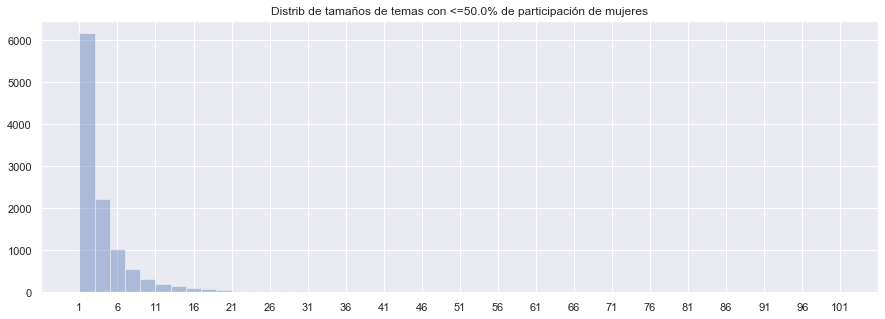

In [687]:
p = .5  #  mujeres participan al menos un p*100% de los mensajes
temas_gens = plot_tema_size(p, at_least=True)

In [691]:
_temas, _gens = list(zip(*temas_gens))
summarize([len(t.mensajes) for t in _temas if len(t.mensajes) >= 10])

Size:	980
Min:	10
Median:	14.0
Max:	101
Avg:	18.90918367346939
Mode:	10


In [692]:
explore_temas(temas_gens, cutoff=20)

M: 12 (48.0%) F: 13 (52.0%) T: 25 - Clases de salsa y bachata en Beauchef
M: 6 (24.0%) F: 19 (76.0%) T: 25 - Zapatillas pintadas a mano
M: 14 (34.1%) F: 27 (65.9%) T: 41 - Nuevo taller de CUECA de BeM
M: 10 (45.5%) F: 12 (54.5%) T: 22 - Semana de Ingenieria Química y Biotecnología
M: 21 (47.7%) F: 23 (52.3%) T: 44 - arriendo pieza cerca de la u
M: 9 (45.0%) F: 11 (55.0%) T: 20 - un me gusta no cuesta nada!
M: 7 (17.9%) F: 32 (82.1%) T: 39 - Se Vende miel!!
M: 8 (16.7%) F: 40 (83.3%) T: 48 - Cereales Naturales con Cranberries, Higos, Papayas o Mango!
M: 8 (23.5%) F: 26 (76.5%) T: 34 - Cereales Premium, Nueces y Almendras cosecha 2015
M: 15 (50.0%) F: 15 (50.0%) T: 30 - Taller Fotográfico: Blanco y Negro
M: 11 (44.0%) F: 14 (56.0%) T: 25 - Mochila perdida
M: 48 (49.0%) F: 50 (51.0%) T: 98 - SEMDA: ¿Negligencia?
M: 10 (50.0%) F: 10 (50.0%) T: 20 - De Zombies a Super Héroes y Super Villanos
M: 10 (50.0%) F: 10 (50.0%) T: 20 - ¡Te invitamos a la Feria Consciente de abril en la FCFM!
M: 17 (

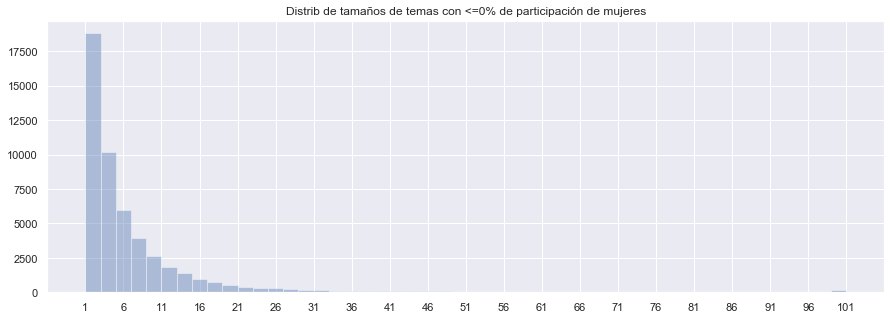

In [677]:
p = 0  #  mujeres participan p*100% de los mensajes
temas_gens = plot_tema_size(p, at_least=False)

In [678]:
_temas, _gens = list(zip(*temas_gens))
summarize([len(t.mensajes) for t in _temas])mul

Size:	49847
Min:	1
Median:	4
Max:	101
Avg:	6.6183922803779565
Mode:	1


In [693]:
explore_temas(temas_gens, cutoff=101)

M: 40 (39.6%) F: 61 (60.4%) T: 101 - Cec
M: 47 (46.5%) F: 54 (53.5%) T: 101 - [VENDO + CONCURSO] Post it magnéticos y pizarras magnéticas
M: 34 (33.7%) F: 67 (66.3%) T: 101 - Concurso D3JAT3 CA3R - Los Tres
M: 34 (33.7%) F: 67 (66.3%) T: 101 - Lo Amo :D
M: 40 (39.6%) F: 61 (60.4%) T: 101 - Carta abierta a la Comunidad de la FCFM
M: 22 (21.8%) F: 79 (78.2%) T: 101 - Ayuda urgente! (Familiar perdido)
M: 28 (27.7%) F: 73 (72.3%) T: 101 - Se regalan Cachupinas


## # de mensajes en el tiempo por género

In [697]:
usuarios_df = pd.DataFrame(((m.autor, m.genero, m.fecha_creacion) for _, m in mensajes.items()), columns=["autor", "genero", "fecha"])

,autor,genero,fecha
0,1,M,2002-03-11 12:16:44
1,1,M,2002-03-14 19:12:12
2,1,M,2002-03-16 09:08:30
3,1,M,2002-03-26 22:27:10
4,1,M,2002-04-03 18:00:13


In [701]:
usuarios_df['mes'] = usuarios_df['fecha'].apply(lambda x: x.strftime("%Y-%m"))

In [703]:
usuarios_df.head()

,autor,genero,fecha,mes
0,1,M,2002-03-11 12:16:44,2002-03
1,1,M,2002-03-14 19:12:12,2002-03
2,1,M,2002-03-16 09:08:30,2002-03
3,1,M,2002-03-26 22:27:10,2002-03
4,1,M,2002-04-03 18:00:13,2002-04


### Mujeres

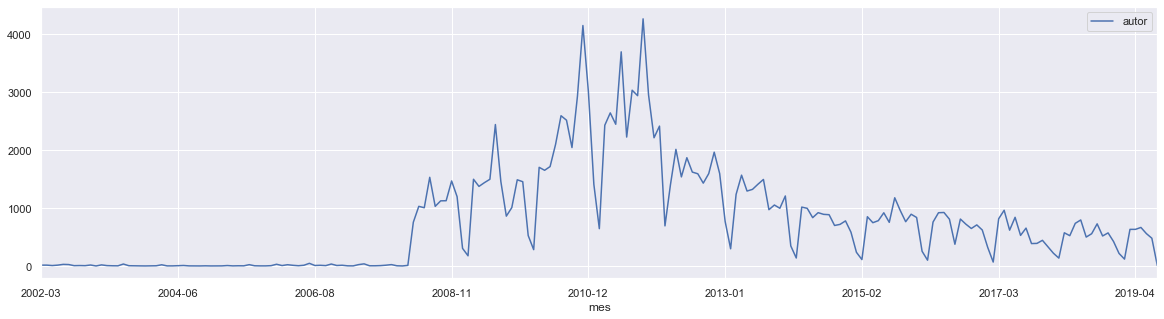

In [704]:
m = usuarios_df.loc[usuarios_df['genero'] == 'F']

counts = m.set_index('mes').groupby('mes').count()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='mes', y='autor')

### Hombres

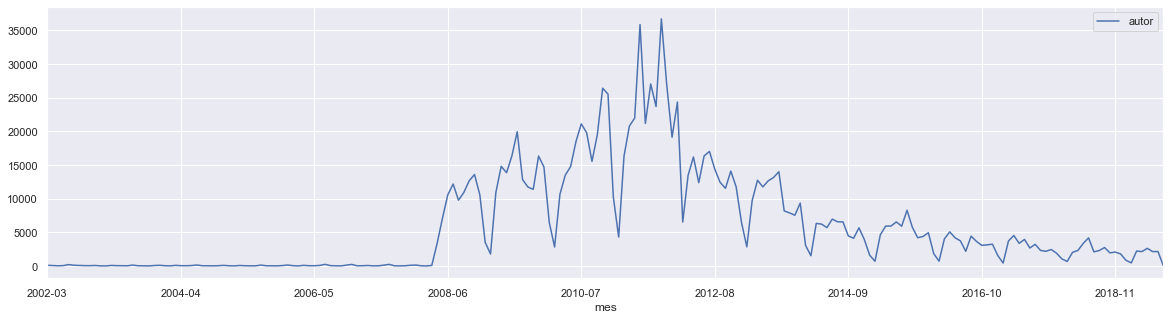

In [705]:
m = usuarios_df.loc[usuarios_df['genero'] == 'M']

counts = m.set_index('mes').groupby('mes').count()
plt.rcParams['figure.figsize'] = [20, 5]
counts.reset_index().plot.line(x='mes', y='autor')

## tamaño del tema => % de participación 

In [708]:
temas_cp[2]

(Tema(raiz=2203704, titulo='Ayuda con TICs y Optimizacion', mensajes=7, conversaciones=6, fecha_creacion='2019-03-14 00:23:19'),
 Counter({'M': 3, 'F': 4}))

In [707]:
explore_temas([temas_cp[2]])

M: 3 (42.9%) F: 4 (57.1%) T: 7 - Ayuda con TICs y Optimizacion


In [710]:
def participacion(tema_size=101, at_least=True):
    """
    participacion H/M para temas de tamaño == tema_size
    si at_least=True, tamaño >= tema_size
    """
    if at_least:
        temas_ = [(tema_, part) for tema_, part in temas_cp if len(tema_.mensajes) >= tema_size]
    else:
        temas_ = [(tema_, part) for tema_, part in temas_cp if len(tema_.mensajes) == tema_size]
        
    return temas_

# Tópicos de discusión

In [716]:
#!python -m spacy init-model es /tmp/sbwc --vectors-loc  /Users/mquezada/IMFD/projects/fb-ss1/data/word_embeddings/fasttext-sbwc.vec.gz

In [718]:
from nltk.corpus import stopwords
from textacy import preprocessing
import spacy
import string

In [715]:
#nlp = spacy.load('es_core_news_sm')  # default

nlp_es = spacy.load('/tmp/sbwc')  # con spanish word embeddings

# tema => vector

Luego comparar temas con mayor part de hombres vs mujeres

In [742]:
vects_h = []
vects_m = []

for tema_, part_ in tqdm(participacion(tema_size=10)):
    h = part_['M']
    m = part_['F']
    
    vects_tema = []
    mensajes_tema_ = tema_.mensajes
    for id in mensajes_tema_:
        msg_ = mensajes[id]
        txt = msg_.contenido
        txt = preprocessing.remove_accents(txt)
        txt = preprocessing.remove_punctuation(txt)
        txt = txt.strip().lower()
        doc = nlp_es(txt)
        vec = doc.vector
        vects_tema.append(vec)
    vec_tema = np.array(vects_tema).mean(axis=0)
    
    if m >= h:
        vects_m.append((tema_.raiz, vec_tema))
    else:
        vects_h.append((tema_.raiz, vec_tema))
    
        

In [761]:
temas_cp[0]

(Tema(raiz=2204304, titulo='Guardarropía', mensajes=7, conversaciones=6, fecha_creacion='2019-03-15 12:51:56'),
 Counter({'M': 6, 'F': 1}))

###  insertar datos en la db

In [785]:
cols = [
    'raiz', 
    'titulo', 
    'fecha_creacion',
    'n_mensajes',  
    'usuarios_unicos', 
    'mensajes_hombres', 
    'mensajes_mujeres',
    'hombres_uniq',
    'mujeres_uniq'
]
rows = []

for tema, part in temas_cp:
    nh = part['M']
    nm = part['F']
    
    nhu = set()
    nmu = set()
    usuarios = set()
    for m in tema.mensajes:
        m_ob = mensajes[m]
        usuarios.add(m_ob.autor)
        if m_ob.genero == 'F':
            nmu.add(m_ob.autor)
        elif m_ob.genero == 'M':
            nhu.add(m_ob.autor)

    rows.append(
        (tema.raiz, 
         tema.titulo, 
         tema.fecha_creacion,
         len(tema.mensajes), 
         len(usuarios),
         nh,
         nm,
         len(nhu),
         len(nmu)
        ))

temas_df = pd.DataFrame(rows, columns=cols)

In [787]:
temas_df.head()

,raiz,titulo,fecha_creacion,n_mensajes,usuarios_unicos,mensajes_hombres,mensajes_mujeres,hombres_uniq,mujeres_uniq
0,2204304,Guardarropía,2019-03-15 12:51:56,7,4,6,1,3,1
1,64582,Ayuden a difundir el plan piloto de la ENCUEST...,2008-08-30 00:11:00,1,1,1,0,1,0
2,2203704,Ayuda con TICs y Optimizacion,2019-03-14 00:23:19,7,3,3,4,2,1
3,2205306,Poleron encontrado b213 en horario 10:15 - 11:45,2019-03-18 15:33:35,2,1,2,0,1,0
4,359250,PAE!,2010-04-14 11:51:09,36,22,32,4,18,4


In [792]:
msgs_tema = []

for raiz, tema in temas.items():
    for m in tema.mensajes:
        m_ob = mensajes[m]
        msgs_tema.append((raiz, m))

In [793]:
cols = ['raiz', 'id_mensaje']
mensajes_df = pd.DataFrame(msgs_tema, columns=cols)

In [794]:
mensajes_df.head()

,raiz,id_mensaje
0,2204304,2204480
1,2204304,2204420
2,2204304,2204476
3,2204304,2204304
4,2204304,2204408


In [795]:
convs = []

for raiz, tema in temas.items():
    for m1, m2 in tema.conversacion:
        convs.append((raiz, m1, m2))

In [796]:
cols = ['raiz', 'id_mensaje_1', 'id_mensaje_2']

convs_df = pd.DataFrame(convs, columns=cols)

In [797]:
convs_df.head()

,raiz,id_mensaje_1,id_mensaje_2
0,2204304,2204480,2204476
1,2204304,2204420,2204412
2,2204304,2204412,2204410
3,2204304,2204408,2204304
4,2204304,2204410,2204304


In [799]:
from sqlalchemy import create_engine

engine = create_engine('mysql+mysqlconnector://root@localhost/ucursos')

In [805]:
temas_df.to_csv('temas.csv', index=False)

In [806]:
mensajes_df.to_csv('mensajes.csv', index=False)
convs_df.to_csv('convs.csv', index=False)